<a href="https://colab.research.google.com/github/Vixuz144/Admin-Prod/blob/main/Sistema_de_inventarios_reducido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [363]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from numba import jit

In [364]:
@jit(nopython = True)
def dot(a, b):
  x = 0
  n = len(a)
  for i in range(n):
    x += a[i]*b[i]
  return x


@jit(nopython = True)
def expo(lam):
  return - np.log(random())/lam

@jit(nopython = True)
def tri(a,b,c):
  x = a + (b-a)*random()
  if a <= x < c:
    t = a + np.sqrt(x*(b-a)*(c-a))
    # print(x, 'a', t)
  else:
    t = b - np.sqrt(((c-a +b - c)/(b-a)-x)*(b-a)*(b-c))
    # print(x, 'b', t)
  return t

@jit(nopython = True)
def pedido():
  r = random()
  if r < 0.11:
    x = 15
  elif r < 0.28:
    x = 30
  elif r < 0.38:
    x = 45
  elif r < 0.58:
    x = 90
  elif r < 0.90:
    x = 105
  else:
    x = 120
  return x*125




@jit(nopython = True)
def argmin(x):
  m = min(x)
  i = 0
  while x[i] != m:
    i+=1
  return i

In [377]:
Q = 1700375
PV = 39
CU = 9
CAF = 25740
CAV = 3000/3146/125
print(CAV)
CA = CAF+CAV*Q
print(CA)
CP = CU*Q
print(CP)
V = PV*Q
print(V)
B = V - CP - CA
print(round(B,2))

0.007628734901462174
38711.71010807375
15303375
66314625
50972538.29


In [366]:
@jit(nopython = True)
def inv_mc(x, lv, lt, Q, cf, cau, caf, T = 365, mes = 30):
  q, p = x
  cap = Q//12
  t = 0
  cost = 0
  vp = 0

  tv = expo(lv)
  tr = np.inf
  lx, ly = [t], [cap]
  t = min(tv, tr)
  while t < T:

    if t == tv: #Venta
      tv = t + expo(lv)
      c = pedido()
      if c <= cap:
        cap -= c
      else:
        vp +=1

      if cap <= p:
        cost += cf*q
        tr = t + expo(lt)

    else: #reposición de inventario
      cap += q
      tr = np.inf

    ta = t
    t = min(tv,tr)
    if ta < mes < t:
      cost += cap*cau
    lx.append(t)
    ly.append(cap)

    cost += caf

  return cost, vp, lx, ly


30888982.062301334 0


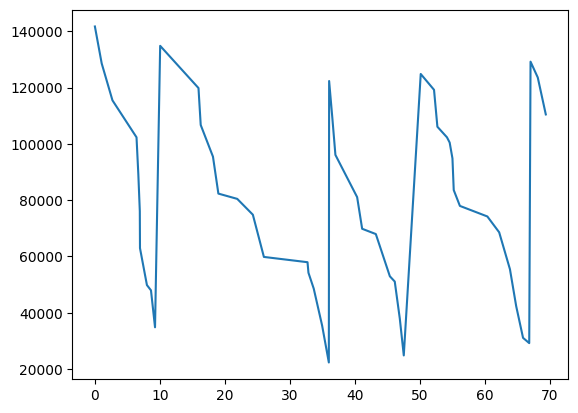

In [425]:
x = 100000, 41500
lv, lr = 0.5, 1
c, vp, lx, ly = inv_mc(x, 0.5, 1, Q, CU, CAV, CAF)
print(c, vp)

n = 50
plt.plot(lx[:n],ly[:n])
plt.show()

In [368]:
@jit(nopython = True)
def sim(x, lv=lv, lt=lr, Q=Q, cf=CU, cau=CAV, caf=CAF, n = 10**3):
  l = []
  for i in range(n):
    c, _, _, _  = inv_mc(x, lv, lt, Q, cf, cau, caf)
    l.append(c)
  return l


In [369]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

27158548.402020343 3324506.1882836875


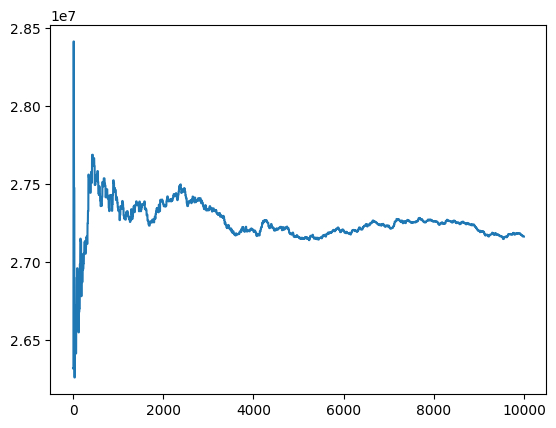

In [370]:
n = 10**4
l = sim(x, n = n)
m = np.mean(l)
s = np.std(l)
print(m, s)
ll = graf(l,10)
plt.plot(ll)
plt.show()

In [371]:
def NM(f, lx0, tol, max_iter):
  lx = np.array(lx0)
  n = len(lx)
  lf = []
  for i in range(n):
    lf.append(f(lx[i]))
  # lf = np.array(lf)
  iter = 0
  print('hola')

  cond1 = not np.allclose(lf[0], lf[-1], rtol = tol)
  cond2 = iter < max_iter
  while cond1 and cond2:
    iter += 1

    #----------------------------------ordenar----------------------------------
    lx = lx[np.argsort(lf)]
    lf.sort()


    #---------------------------encontrar punto medio---------------------------
    suma = np.sum(lx[:-1], 0)
    c = suma/(n-1)

    #---------------------------------reflejar----------------------------------
    x = c + (c - lx[-1])
    fx = f(x)
    print(fx)

    #---------------------------------expansion---------------------------------
    if fx < lf[0]:
      xx = c + 2*(c - lx[-1])
      fxx = f(xx)
      if fxx < lf[0]:
        lx[-1] = xx
        lf[-1] = fxx
      else:
        lx[-1] = x
        lf[-1] = fx
    elif fx < lf[-2]:
      lx[-1] = x
      lf[-1] = fx
    else:
      #-------------------------------contraccion-------------------------------
      x1 = c + 0.5*(c - lx[-1])
      x2 = c - 0.5*(c - lx[-1])
      f1 = f(x1)
      f2 = f(x2)
      if f1 < lf[-1] and f1 < f2:
        lx[-1] = x1
        lf[-1] = f1
      elif f2 < lf[-1] and f2 < f1:
        lx[-1] = x2
        lf[-1] = f2
      #--------------------------------reduccion--------------------------------
      else: #Reduccion
        for i in range(1,n):
          lx[i] = lx[0] - 0.5*(lx[0] - lx[i])
          lf[i] = f(lx[i])
    #-------------------Restriccion de capacidades del almacen------------------
    for k in range(len(lx)):
      x1, x2, x3 = lx[k] * np.ones(6), lx[k] * np.ones(6), lx[k] * np.ones(6)
      for i in range(3):
        if x1[i] > x1[i+3]:
          x1[i] = x1[i+3] - 1
          x2[i+3] = x2[i] + 1
          a = float(x3[i])
          x3[i] = float(x3[i+3])
          x3[i+3] = a
          f1 = f(x1)
          f2 = f(x2)
          f3 = f(x3)
          m = min(f1, f2, f3)
          if m == f1:
            lx[k] = x1
          elif m == f2:
            lx[k] = x2
          else:
            lx[k] = x3
    cond1 = not np.allclose(lf[0], lf[-1], rtol = tol)
    cond2 = iter < max_iter
  return lx, lf

In [372]:
@jit(nopython = True)
def rep(x, lv=lv, lt=lr, Q=Q, cf=CU, cau=CAV, caf=CAF, nr = 10**2, ns = 5*10**3):
  j = []
  for i in range(nr):
    l = sim(x, n=ns)
    l = np.array(l)
    m = l.mean()
    j.append(m)
  j = np.array(j)
  return j.mean()

In [373]:
m = rep(x)
print(m)

27161436.30132176


In [398]:
y = [[65400, 37511], [50001.1, 41500], [47800, 42500]]
lx, lf = NM(rep, y, 10**-1, 100)

hola


In [399]:
print(lx)
print(lf)
xx = lx[np.argmin(lf)]
print(xx)

[[65400.  37511. ]
 [50001.1 41500. ]
 [47800.  42500. ]]
[27286400.390992388, 27444997.734054636, 27496557.68539933]
[65400. 37511.]


30818410.970120788 0


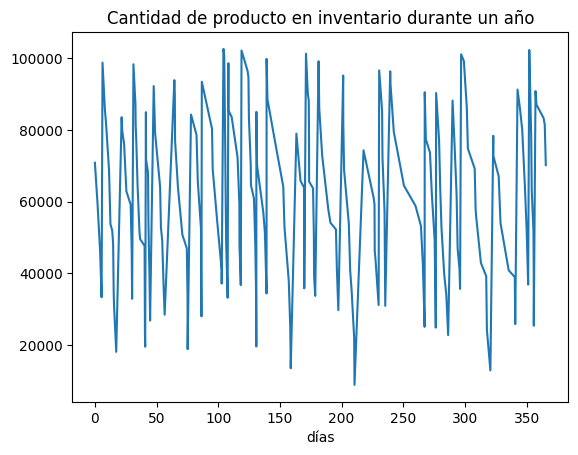

In [423]:
c, vp, lx, ly = inv_mc(xx, 0.5, 1, Q//2, CU, CAV, CAF)
print(c, vp)

plt.plot(lx,ly)
plt.ylabel('gramos')
plt.xlabel('días')
plt.title('Cantidad de producto en inventario durante un año')
plt.show()

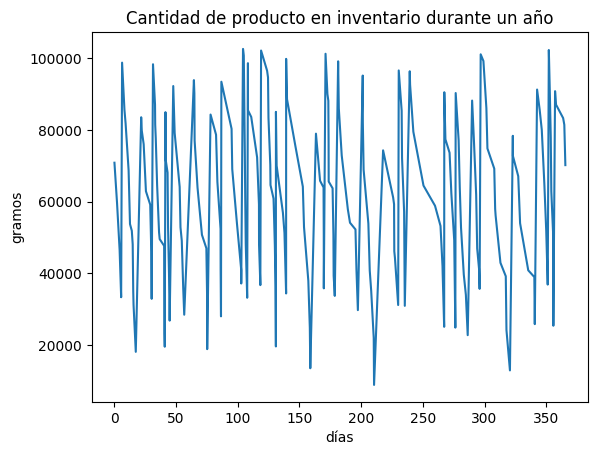

In [424]:
plt.plot(lx,ly)
plt.ylabel('gramos')
plt.xlabel('días')
plt.title('Cantidad de producto en inventario durante un año')
plt.show()